In [13]:
from tensorflow import keras
import tensorflow as tf

# Load and predict model

In [119]:
model = keras.models.load_model('../my_scripts/models/EfficientNet/simple_665_0.89.h5')

In [14]:
IMG_PIXELS = 224
image_size = (IMG_PIXELS, IMG_PIXELS)
img = keras.preprocessing.image.load_img('../data/test/cardboard1.jpg', target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [17]:
prediction = model.predict(img_array)

In [23]:
target_classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
target_classes[tf.math.argmax(prediction[0]).numpy()]

'cardboard'

# Load testing set

In [27]:
from tqdm import tqdm 
import pathlib 
import os

base_dir = pathlib.Path('..')
data_test = base_dir / 'data' / 'test'

def make_target_test_classes():
    for target_cls in target_classes:
        if os.path.exists(data_test / target_cls):
            print(f'path {data_test/target_cls} exists')
            print(target_cls, len(os.listdir(data_test / target_cls)))
        else: 
            os.makedirs(data_test / target_cls)
            print(f'path {data_test/target_cls} created')

def move_test_images(): 
    # copy files to train folder classes folder 
    for img_file in tqdm(os.listdir(data_test)):
        if img_file.endswith('.jpg'):
            img_path = data_test / img_file
            for target_cls in target_classes:
                if img_file.startswith(target_cls):
                    img_path.rename(data_test / target_cls / img_file)

In [28]:
make_target_test_classes()

path ..\data\test\cardboard created
path ..\data\test\glass created
path ..\data\test\metal created
path ..\data\test\paper created
path ..\data\test\plastic created
path ..\data\test\trash created


In [29]:
move_test_images()

100%|██████████| 767/767 [00:01<00:00, 743.18it/s]


In [41]:
def load_test_data():

    print('Loading test data')
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        '../data/test',
        validation_split=0,
        label_mode="categorical",
        seed=1337,
        image_size=image_size,
        batch_size=100,
    )
    return test_ds


In [42]:
test_ds = load_test_data()

Loading test data
Found 761 files belonging to 6 classes.


In [55]:
len(test_ds), type(test_ds)

(8, tensorflow.python.data.ops.dataset_ops.BatchDataset)

In [53]:
import numpy as np
np.array(test_ds.take(1))

array(<TakeDataset shapes: ((None, 224, 224, 3), (None, 6)), types: (tf.float32, tf.float32)>,
      dtype=object)

In [120]:
predictions = model.predict(test_ds)

In [123]:
test_loss, test_acc = model.evaluate(test_ds)
test_loss, test_acc

8/8 [==============================] - 7s 826ms/step - loss: 11.6848 - accuracy: 0.7254


(11.684842109680176, 0.7253613471984863)

In [124]:
predictions.shape

(761, 6)

In [125]:
# for pred_int in predictions.argmax(axis=1):
#     print(target_classes[pred_int])
one_hot_labels = np.concatenate([y for x,y in test_ds])
one_hot_labels.shape, predictions.shape

((761, 6), (761, 6))

In [126]:
from sklearn import metrics 
cm = metrics.confusion_matrix(y_true=one_hot_labels.argmax(axis=1), y_pred=predictions.argmax(axis=1))#, labels=target_classes)
print(target_classes)
cm

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


array([[17, 26, 11, 41, 19,  7],
       [23, 31, 12, 46, 32,  7],
       [16, 20,  8, 40, 34,  5],
       [28, 36, 20, 47, 45,  3],
       [27, 25, 10, 42, 28, 13],
       [ 7,  9,  7,  7, 10,  2]], dtype=int64)

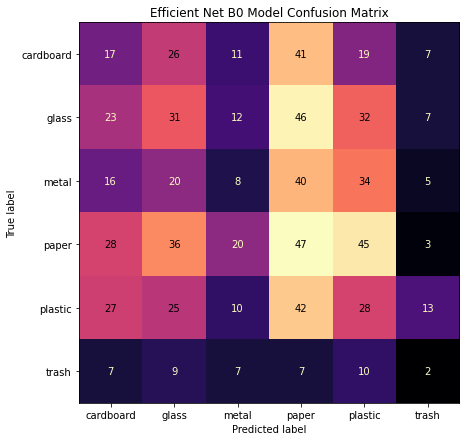

In [127]:
f = plt.figure(figsize=(10,7))
ax = f.add_subplot(111)
plt.title('Efficient Net B0 Model Confusion Matrix')
metrics.ConfusionMatrixDisplay.from_predictions(y_true=one_hot_labels.argmax(axis=1), y_pred=predictions.argmax(axis=1), display_labels=target_classes,cmap='magma', ax=ax, colorbar=False)
plt.savefig('../my_scripts/plots/EfficientNet/confusion_matrix.jpg')